##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Generalized Gumbel-max causal mechanisms tutorial

This notebook explains the APIs of the Gumbel-max causal mechanism implementation, along with those of our two gadgets.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/google-research/blob/master/gumbel_max_causal_gadgets/tutorial.ipynb)

## Setting up the environment

These instructions are designed for running this tutorial using Google Colab; if you are using a different environment, the setup instructions may differ!

If you want to follow along, the first step is to connect the Colab runtime to a TPU. You can use the "Runtime > Change runtime type" option in the toolbar above. You can also stick with a CPU or GPU runtime, but this will be slower and you may have to adjust batch sizes.

Next, install necessary dependencies:

In [ ]:
# Download the codebase
!git clone https://github.com/google-research/google-research.git --depth=1

Cloning into 'google-research'...
remote: Enumerating objects: 10043, done.
remote: Counting objects: 100% (10043/10043), done.
remote: Compressing objects: 100% (8038/8038), done.
remote: Total 10043 (delta 1443), reused 7963 (delta 1209), pack-reused 0
Receiving objects: 100% (10043/10043), 109.57 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (1443/1443), done.
Checking out files: 100% (10525/10525), done.


In [ ]:
import os
os.chdir("google-research")

In [ ]:
# Install Python packages
!pip install flax optax

If you are using a TPU, make sure JAX can see it:

In [ ]:
# See https://github.com/google/jax/blob/master/cloud_tpu_colabs/JAX_demo.ipynb
import requests
import os

if 'COLAB_TPU_ADDR' not in os.environ:
  raise RuntimeError("Please connect to a TPU runtime first!")

if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# Use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.48.40.138:8470


In [ ]:
import jax
jax.devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, host_id=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, host_id=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, host_id=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(1,1,0), core_on_chip=1)]

You should see 8 TPU devices connected above!

## Imports and configuration

In [ ]:
import functools
import time
from typing import *

import numpy as np
import jax
import jax.numpy as jnp
import optax
import flax
import flax.linen as nn

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.ion()
np.set_printoptions(linewidth=150)

In [ ]:
from gumbel_max_causal_gadgets import coupling_util
from gumbel_max_causal_gadgets import gadget_1
from gumbel_max_causal_gadgets import gadget_2
from gumbel_max_causal_gadgets import experiment_util

## The Gumbel-max causal mechanism and Gumbel-max coupling

We start with the Gumbel-max causal mechanism, as introduced in "Counterfactual off-policy evaluation with Gumbel-max structural causal models" [(Oberst and Sontag, 2019)](http://proceedings.mlr.press/v97/oberst19a.html).

Suppose we wish to sample an observation $x$ from an interventional distribution $p(x | do(y)) \propto \exp l_x$, defined by a vector of logits $l \in \mathbb{R}^k$. We can do this by first sampling a vector of Gumbel(0) exogenous noise $\gamma$, then shifting it by $l$ and taking the argmax:

In [ ]:
def sample_gumbel_max(rng, logits):
  gumbels = jax.random.gumbel(rng, logits.shape)
  x = jnp.argmax(gumbels + logits)
  return x

If we wish to jointly sample two outcomes under two interventions, we can do so by passing two different logit vectors while re-using the same `gumbels`. Because `rng` determines the samples of Gumbels, we can do this by passing the same `rng` value:

In [ ]:
# Two fairly arbitrary logit vectors
p_logits = 0.1 * jnp.arange(10) - (10 - 1.0) / 2
q_logits = -p_logits
p_logits = p_logits - jax.scipy.special.logsumexp(p_logits)
q_logits = q_logits - jax.scipy.special.logsumexp(q_logits)
print("p_probs", jnp.exp(p_logits))
print("q_probs", jnp.exp(q_logits))

p_probs [0.06120515 0.0676421  0.07475634 0.08261816 0.09130762 0.10091028 0.11152306 0.12325207 0.1362144  0.15054083]
q_probs [0.15054086 0.13621445 0.12325212 0.11152306 0.10091028 0.09130762 0.08261816 0.07475635 0.06764212 0.06120515]


In [ ]:
keys = jax.random.split(jax.random.PRNGKey(42), 10)
p_samples = []
q_samples = []
for prng_key in keys:
  p_samples.append(int(sample_gumbel_max(prng_key, p_logits)))
  q_samples.append(int(sample_gumbel_max(prng_key, q_logits)))

print("p_samples", p_samples)
print("q_samples", q_samples)

p_samples [9, 5, 2, 2, 2, 1, 4, 9, 7, 1]
q_samples [0, 5, 2, 2, 2, 0, 0, 9, 7, 1]


Note that the samples from $p$ and $q$ are the same more often than they would be if we drew them independently. This is because they share the same exogenous noise, and only have different interventional distributions. We can repeat this for a larger number of samples to visualize the resulting *Gumbel-max coupling* between $p$ and $q$:

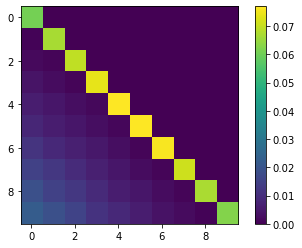

In [ ]:
gm_coupling_p_q = coupling_util.joint_from_samples(
    coupling_util.gumbel_max_sampler,
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)
plt.imshow(gm_coupling_p_q, vmin=0)
plt.colorbar()

### The Gumbel-max coupling v.s. a maximal coupling

Notice that a lot of mass is on the diagonal. We might wonder if the diagonal contains as much mass as possible, e.g. is this a maximal coupling? However, as we show in Section 4, the answer is no.

For comparison, we can construct a maximal coupling (which does not correspond to a causal mechanism, but is instead defined directly with respect to `p_logits` and `q_logits`):

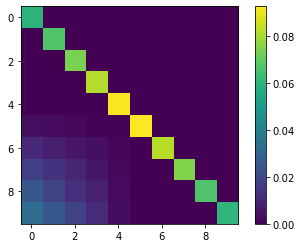

In [ ]:
maximal_coupling_p_q = coupling_util.joint_from_samples(
    coupling_util.maximal_coupling_sampler,
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)
plt.imshow(maximal_coupling_p_q, vmin=0)
plt.colorbar()

We can plot the difference between the two, which reveals that the Gumbel-max sampler assigns less mass to the diagonal, and more mass to the off diagonal elements.

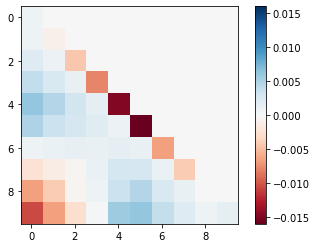

In [ ]:
difference = gm_coupling_p_q - maximal_coupling_p_q
plt.imshow(difference, vmin=-0.016, vmax=0.016, cmap="RdBu")
plt.colorbar()

### Using the Gumbel-max SCM to sample counterfactuals

We can use the top-down sampling algorithm [(Maddison et al. [2014])](https://arxiv.org/abs/1411.0030) to answer counterfactual queries: given that we observed $x^{(obs)}$ under `p_logits`, what would we have observed under `q_logits`?

The key insight is that the maximum value and the argmax are independent for a set of independent shifted Gumbels (as explained [here](https://cmaddis.github.io/gumbel-machinery)). $x^{(obs)}$ is the argmax, so we can sample the exogenous noise by sampling the max, then filling in the rest.

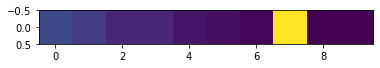

In [ ]:
x_obs = 7  # for example
rng = jax.random.PRNGKey(1234)

# Use jax.vmap to draw many samples
def sample_one(key):
  gumbels = coupling_util.counterfactual_gumbels(p_logits, x_obs, key)
  y_for_q = jnp.argmax(gumbels + q_logits)
  return jnp.zeros([10]).at[y_for_q].set(1.)

counterfactual_y = jnp.mean(jax.vmap(sample_one)(jax.random.split(rng, 1000)), axis=0)
plt.imshow(counterfactual_y[None, :], vmin=0)

This is equivalent to sampling only within a single row (row 7) of the coupling matrix in the previous section.

The key property that makes this useful for counterfactual inference is that it works for any `x_obs`, even one that we did not sample using our mechanism, as long as the value of `x_obs` can be viewed as a sample from the distribution given by `p_logits`. Thus, it can be used to infer counterfactual distributions for data collected offline by interacting with the real world, as described by Oberst and Sontag (2017).

## Inverse-CDF couplings and monotonicity



Another interesting class of coupling is the "inverse CDF" causal mechanism and resulting coupling. If we define an order on the outcomes, we can use this to construct the cumulative distribution function, or CDF, for any particular logit vector $l$. It turns out that inverting the CDF and evaluating it at a sample of uniform random noise will produce a sample from the desired distribution.

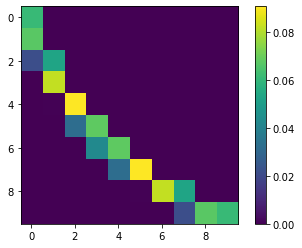

In [ ]:
inverse_cdf_p_q = coupling_util.inverse_cdf_coupling(
    logits_1=p_logits,
    logits_2=q_logits)
plt.imshow(inverse_cdf_p_q, vmin=0)
plt.colorbar()

As we discuss in Section 2, if we are interested in measuring a difference of costs with minimum variance, and each cost function is monotonic with respect to this ordering, it turns out that this coupling will always minimize the variance. However, this is only possible if we know the ordering in advance while building our causal mechanism. If we use a different order, we destroy this structure.

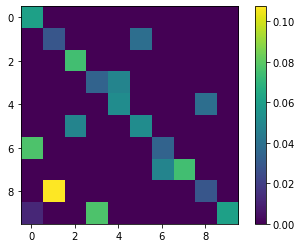

In [ ]:
perm_inverse_cdf_p_q = coupling_util.permuted_inverse_cdf_coupling(
    logits_1=p_logits,
    logits_2=q_logits,
    permutation_seed=1)
plt.imshow(perm_inverse_cdf_p_q, vmin=0)
plt.colorbar()

## Independent couplings

One other class of couplings that we compare against is the independent coupling, which implies that $p(x)$ and $q(y)$ have nothing in common. From a causal perspective, this corresponds to a situation where the outcome for an observation tells you nothing at all about what the outcome would have been for some other counterfactual intervention.

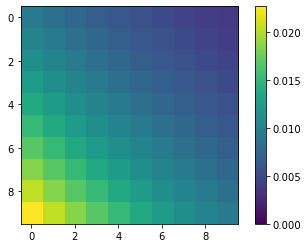

In [ ]:
independent_pq = coupling_util.independent_coupling(
    logits_1=p_logits,
    logits_2=q_logits)
plt.imshow(independent_pq, vmin=0)
plt.colorbar()

## Gadget 1 and Gadget 2

We now show how to use our learnable "gadgets" to define couplings and to draw samples from a counterfactual.

As discussed in Section 5.1, Gadget 1 deviates from a normal SCM in that the exogenous noise is not shared exactly between the "observed" and "counterfactual" samples. In particular, sampling from a counterfactual distribution requires transposing the matrix of Gumbels, and thus requires designating one of the interventions as the non-transposed original and the other as the transposed counterfactual.

Gadget 2, on the other hand, satisfies the normal requirements of an SCM, and uses the same exogenous noise across all possible interventions. This means that it can be used in the same set of situations as the Gumbel-max SCM.

Both gadgets are implemented as `flax` modules, which separate the definition of the model class $\{f_\theta\}_{\theta \in \Theta}$ from the specific value of the parameters $\theta$. We can instantiate each model class by specifying all of the necessary hyperparameters. For instance:

In [ ]:
# S_dim is the number of outcomes for our distribution of interest.
gadget_1_def = gadget_1.GadgetOneMLPPredictor(
    S_dim=10, hidden_features=[1024, 1024],
    relaxation_temperature=1.0)

# Gadget 2 also requires Z_dim, the space of the latent auxiliary variable.
gadget_2_def = gadget_2.GadgetTwoMLPPredictor(
    S_dim=10, Z_dim=100, hidden_features=[1024, 1024],
    relaxation_temperature=1.0, learn_prior=False)

To use them to draw samples, we must pick a particular value for $\theta$. We can start by randomly initializing each:

In [ ]:
init_key = jax.random.PRNGKey(1001)
gadget_1_theta = gadget_1_def.init(init_key, jnp.zeros([gadget_1_def.S_dim]))

init_key = jax.random.PRNGKey(1002)
gadget_2_theta = gadget_2_def.init(init_key, jnp.zeros([gadget_2_def.S_dim]))

# Summarize the shape of each parameter tree:
print("Gadget 1:")
print(jax.tree_map(lambda x: f"dtype={x.dtype} shape={x.shape} values={x.reshape([-1])[:4]}...", gadget_1_theta))
print("Gadget 2:")
print(jax.tree_map(lambda x: f"dtype={x.dtype} shape={x.shape} values={x.reshape([-1])[:4]}...", gadget_2_theta))

Gadget 1:
FrozenDict({
    params: {
        hidden_layers_0: {
            bias: 'dtype=float32 shape=(1024,) values=[0. 0. 0. 0.]...',
            kernel: 'dtype=float32 shape=(10, 1024) values=[-0.15586396  0.5272869   0.4646582  -0.02859419]...',
        },
        hidden_layers_1: {
            bias: 'dtype=float32 shape=(1024,) values=[0. 0. 0. 0.]...',
            kernel: 'dtype=float32 shape=(1024, 1024) values=[-0.06402664  0.04275425  0.02152653  0.04715597]...',
        },
        output_layer: {
            bias: 'dtype=float32 shape=(10, 10) values=[0. 0. 0. 0.]...',
            kernel: 'dtype=float32 shape=(1024, 10, 10) values=[-0.05078484 -0.00499428 -0.03920213  0.02491564]...',
        },
    },
})
Gadget 2:
FrozenDict({
    params: {
        hidden_layers_0: {
            bias: 'dtype=float32 shape=(1024,) values=[0. 0. 0. 0.]...',
            kernel: 'dtype=float32 shape=(10, 1024) values=[-0.33588853  0.00931741  0.5640103  -0.3365479 ]...',
        },
        hidd

We can also bind a particular value of $\theta$ to each model definition to obtain a concrete mechanism $f_\theta$. (This is only recommended for interactive use cases, such as this notebook. If you want to learn $\theta$, it's better to keep the two separate. See the [flax documentation](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html) for more details on using flax.)

In [ ]:
gadget_1_at_init = gadget_1_def.bind(gadget_1_theta)
gadget_2_at_init = gadget_2_def.bind(gadget_2_theta)

### Sampling from the gadgets

Given a bound gadget, we can draw samples similarly to Gumbel-max. Each gadget defines a method `sample`, which can be used to draw samples according to their structural causal model. Just like for Gumbel-max, using the same random number generator for two different logit vectors produces coupled interventions. However, as noted before, Gadget 1 requires passing a special `transpose` argument when sampling the second logit vector.

In [ ]:
keys = jax.random.split(jax.random.PRNGKey(42), 20)
g1_p_samples = []
g1_q_samples = []
g2_p_samples = []
g2_q_samples = []
for prng_key in keys:
  # Gadget 1
  g1_p_samples.append(int(gadget_1_at_init.sample(p_logits, prng_key)))
  g1_q_samples.append(int(gadget_1_at_init.sample(q_logits, prng_key, transpose=True)))
  # Gadget 2
  g2_p_samples.append(int(gadget_2_at_init.sample(p_logits, prng_key)))
  g2_q_samples.append(int(gadget_2_at_init.sample(q_logits, prng_key)))

print("g1_p_samples", g1_p_samples)
print("g1_q_samples", g1_q_samples)
print()
print("g2_p_samples", g2_p_samples)
print("g2_q_samples", g2_q_samples)

g1_p_samples [2, 1, 2, 6, 1, 1, 3, 4, 9, 2, 7, 4, 8, 5, 0, 6, 2, 9, 5, 4]
g1_q_samples [8, 5, 8, 6, 5, 4, 9, 1, 4, 0, 6, 1, 2, 1, 7, 2, 2, 2, 6, 5]

g2_p_samples [4, 0, 8, 7, 6, 0, 7, 3, 6, 6, 2, 1, 7, 7, 2, 4, 6, 3, 2, 8]
g2_q_samples [4, 0, 1, 7, 1, 0, 1, 3, 1, 6, 2, 1, 2, 2, 2, 4, 6, 3, 2, 1]


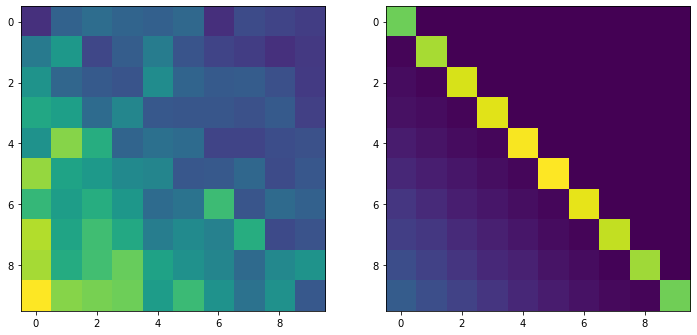

In [ ]:
g1_init_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_1_at_init.sample, second_kwargs={"transpose": True}),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)
g2_init_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_2_at_init.sample),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)

_, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].imshow(g1_init_pq, vmin=0)
axs[1].imshow(g2_init_pq, vmin=0)

(Note: Gadget 2, even at initialization, has similar behavior to Gumbel-max, in that it tends to produce samples that are the same across $p$ and $q$. Gadget 1, on the other hand, often draws distinct samples at initialization, because the exogenous noise is transposed.)

### Drawing counterfactual samples

Each gadget also provides a method `gadget.counterfactual_sample(p_logits, q_logits, p_observed, rng)`. This method serves a similar role as the counterfactual sampling for Gumbel-max SCMs: it allows us to draw a sample from the counterfactual distribution `q_logits`, conditioned on a particular observation from `p_logits`.

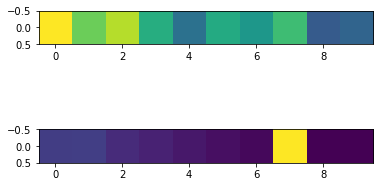

In [ ]:
x_obs = 7  # for example
rng = jax.random.PRNGKey(1234)

def sample_ctf_gadgets(key):
  y_from_gadget_1 = gadget_1_at_init.counterfactual_sample(p_logits, q_logits, x_obs, key)
  y_from_gadget_2 = gadget_2_at_init.counterfactual_sample(p_logits, q_logits, x_obs, key)
  return (
      jnp.zeros([10]).at[y_from_gadget_1].set(1.),
      jnp.zeros([10]).at[y_from_gadget_2].set(1.),
  )

from_p, from_q = jax.vmap(sample_ctf_gadgets)(jax.random.split(rng, 1000))
from_p = jnp.mean(from_p, axis=0)
from_q = jnp.mean(from_q, axis=0)
_, axs = plt.subplots(nrows=2)
axs[0].imshow(from_p[None, :], vmin=0)
axs[1].imshow(from_q[None, :], vmin=0)

As before, these correspond to the 7th row of the full joint distribution shown in the previous section.

### Sampling differentiable continuous relaxations

To train the gadgets, we additionally provide a method `relaxed_sample`, which continuously relaxes the Gumbel-max operations inside each gadget to instead be Gumbel-softmax operations. The default temperature is specified when initializing the gadget, and determines the tradeoff between higher gradient variance and more gradient bias.

Below, we compare the discrete samples with their continuously relaxed counterparts, where each row is a new sample. Note that the discrete sample is always the same as the position of the maximum in the continuous version.

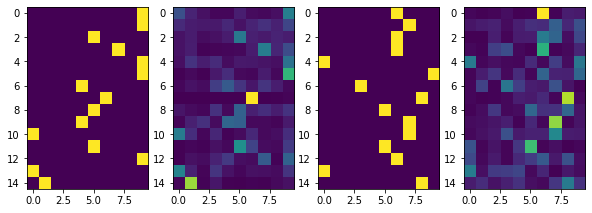

In [ ]:
def draw_relaxed_from_p(key):
  k1, k2 = jax.random.split(key)
  return (
      jnp.zeros([10]).at[gadget_1_at_init.sample(p_logits, k1)].set(1),
      gadget_1_at_init.sample_relaxed(p_logits, k1),
      jnp.zeros([10]).at[gadget_2_at_init.sample(p_logits, k2)].set(1),
      gadget_2_at_init.sample_relaxed(p_logits, k2),
  )

g1_samples, g1_relaxed_samples, g2_samples, g2_relaxed_samples = jax.vmap(draw_relaxed_from_p)(jax.random.split(jax.random.PRNGKey(3), 15))

_, axs = plt.subplots(ncols=4, figsize=(10,4))
axs[0].imshow(g1_samples, vmin=0)
axs[1].imshow(g1_relaxed_samples, vmin=0)
axs[2].imshow(g2_samples, vmin=0)
axs[3].imshow(g2_relaxed_samples, vmin=0)

If we simultaneously draw relaxed samples from $p$ and $q$, again using the same exogenous noise, we can obtain a differentiable estimate of the implicit coupling between them (shown only for gadget 2):

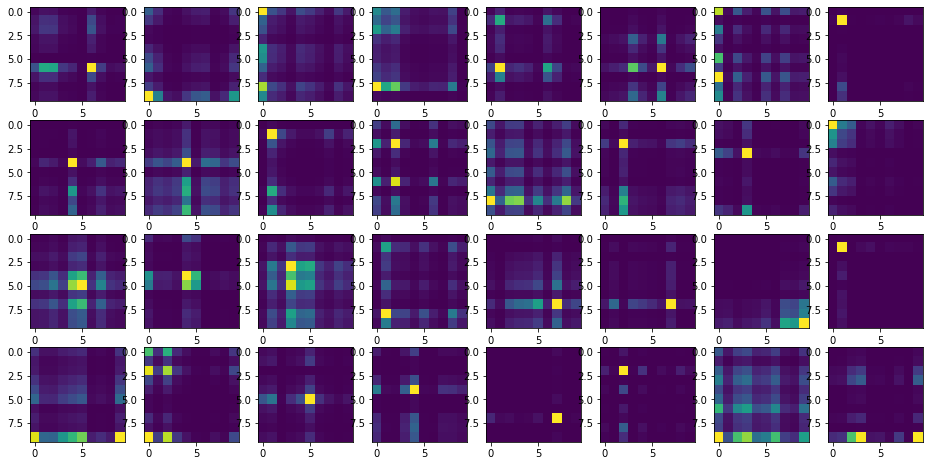

In [ ]:
def gen_soft_pair(key):
  soft_x = gadget_2_at_init.sample_relaxed(p_logits, key)
  soft_y = gadget_2_at_init.sample_relaxed(q_logits, key)
  return (soft_x[:, None] * soft_y[None, :])

soft_pairs = jax.vmap(gen_soft_pair)(jax.random.split(jax.random.PRNGKey(1), 4*8))
_, axs = plt.subplots(nrows=4, ncols=8, figsize=(16,8))
for i in range(4):
  for j in range(8):
    axs[i, j].imshow(soft_pairs[np.ravel_multi_index((i,j), (4,8))])

Over a large number of samples, these soft pairs will tend to approximate a noisier version of the implicit coupling. We can thus use stochastic gradient descent to optimize this coupling to have a better score under our objective of interest.

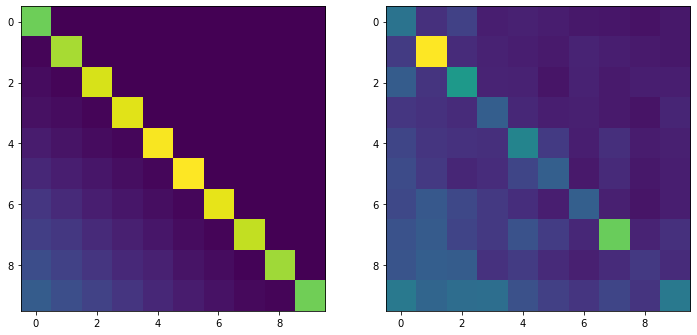

In [ ]:
_, axs = plt.subplots(ncols=2, figsize=(12,6))
# True implicit coupling defined by gadget 2
axs[0].imshow(g2_init_pq, vmin=0)
# Relaxed approximation with gradients
axs[1].imshow(jnp.mean(soft_pairs, axis=0), vmin=0)

### Training the gadgets

So far, we have described how to use the gadgets once we know a particular value for $\theta$. It remains to see how we can *learn* $\theta$ to optimize an objective of interest.

To this end, we provide a training helper class `CouplingExperimentConfig` which allows either of our gadgets to be trained to minimize a particular objective over a distribution of interest. In order to use this, you must provide
- a model definition (either gadget 1 or gadget 2)
- a function that generates random pairs of logits according to the distribution of interest (this is $\mathcal{D}$ from Section 3)
- a function that takes a pair of logits, and returns a matrix of scores for each pair of counterfactual samples  (this is $g_{l^{(1)}, l^{(2)}}$ from Section 3)
- a flag specifying whether it should pass the `transpose` argument during training (True for gadget 1, False otherwise)
- hyperparameters that control the training process, such as the batch size, number of samples per iteration, and optimizer.

To show how this works, here is an example of training each of our gadgets based on two distance functions:
- $g(x, y) = 0\text{ if }x=y\text{ else }1$, which encourages our coupling to be closer to a maximal coupling.
- $g(x, y) = (x-y)^2$, which encourages our coupling to minimize the variance of the difference between the sampled indices.

In both cases, we take the pair of $p$ and $q$ we have used for the rest of this notebook, and perturb it with a small amount of noise, so that it represents a distribution of intervention pairs.

In [ ]:
def logit_pair_distribution_fn(rng, dim, base_scale=.1, noise_scale=.1):
  p_rng, q_rng = jax.random.split(rng, 2)
  p_base = jnp.arange(dim) - (dim - 1.0) / 2
  q_base = -p_base
  p_logits = base_scale * p_base + noise_scale * jax.random.normal(p_rng, (dim,))
  q_logits = base_scale * q_base + noise_scale * jax.random.normal(q_rng, (dim,))
  return p_logits, q_logits

def maximal_coupling_loss_matrix_fn(logits1, logits2):
  return 1.0 - jnp.eye(logits1.shape[0])

def squared_loss_matrix_fn(logits1, logits2):
  seq = jnp.arange(logits1.shape[0]).astype(jnp.float32)
  return jnp.square(seq[None, :] - seq[:, None])

experiments = []
S_dim = 10
Z_dim = 100
for task_fn in [maximal_coupling_loss_matrix_fn, squared_loss_matrix_fn]:
  for gadget in [1, 2]:
    ex = experiment_util.CouplingExperimentConfig(
      name=f"Gadget {gadget} example training: {task_fn.__name__}",
      model=(
          gadget_1.GadgetOneMLPPredictor(
              S_dim=S_dim,
              hidden_features=[1024, 1024],
              relaxation_temperature=1.0)
          if gadget == 1 else
          gadget_2.GadgetTwoMLPPredictor(
              S_dim=S_dim,
              Z_dim=Z_dim,
              hidden_features=[1024, 1024],
              relaxation_temperature=1.0,
              learn_prior=False)
      ),
      logit_pair_distribution_fn=functools.partial(
          logit_pair_distribution_fn,
          dim=S_dim,
          base_scale=.1,
          noise_scale=0.4),
      coupling_loss_matrix_fn=task_fn,
      inner_num_samples=16,
      batch_size=64,
      use_transpose=(gadget == 1),
      tx=optax.adam(1e-5),
      num_steps=2001,
      print_every=1000,
    )
    experiments.append(ex)

In [ ]:
results = []
for ex in experiments:
  print("=" * 80)
  print(ex.name)
  print("=" * 80)
  results.append(ex.train(jax.random.PRNGKey(42)))
  print()

Gadget 1 example training: maximal_coupling_loss_matrix_fn
0 [0.415093544159971/s]: {'loss': 0.9031264781951904}
1 [45.45094384603715/s]: {'loss': 0.8943442106246948}
2 [45.701036207328634/s]: {'loss': 0.8932415246963501}
4 [88.22684055532183/s]: {'loss': 0.9056380987167358}
8 [163.0755832037325/s]: {'loss': 0.8966594934463501}
16 [279.7041779200427/s]: {'loss': 0.8993789553642273}
32 [440.7141384224386/s]: {'loss': 0.880661129951477}
64 [607.2293639411309/s]: {'loss': 0.8530983328819275}
128 [769.3632554326954/s]: {'loss': 0.7658456563949585}
256 [818.5305475258273/s]: {'loss': 0.7173289060592651}
512 [925.5900322568966/s]: {'loss': 0.7053819298744202}
1000 [974.601638636276/s]: {'loss': 0.7030174732208252}
1024 [536.8336915307206/s]: {'loss': 0.6978696584701538}
2000 [943.7588191789362/s]: {'loss': 0.7032415866851807}

Gadget 2 example training: maximal_coupling_loss_matrix_fn
0 [0.15267588040440816/s]: {'loss': 0.6873835325241089}
1 [41.52899591076962/s]: {'loss': 0.6821764707565308

In [ ]:
gadget_1_maximal_theta = results[0].params
gadget_1_maximal = experiments[0].model.bind(gadget_1_maximal_theta)

gadget_2_maximal_theta = results[1].params
gadget_2_maximal = experiments[1].model.bind(gadget_2_maximal_theta)

gadget_1_variance_theta = results[2].params
gadget_1_variance = experiments[2].model.bind(gadget_1_variance_theta)

gadget_2_variance_theta = results[3].params
gadget_2_variance = experiments[3].model.bind(gadget_2_variance_theta)

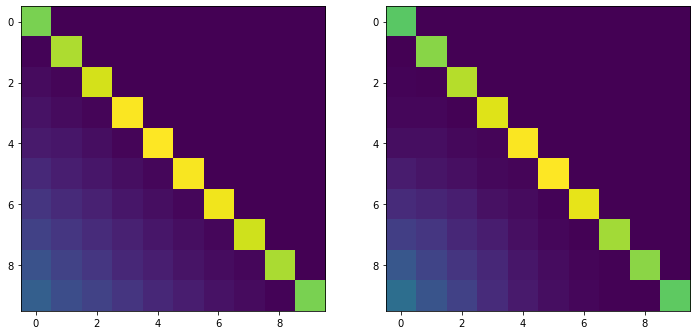

In [ ]:
g1_maximal_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_1_maximal.sample, second_kwargs={"transpose": True}),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)
g2_maximal_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_2_maximal.sample),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)

_, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].imshow(g1_maximal_pq, vmin=0)
axs[1].imshow(g2_maximal_pq, vmin=0)

We see that, after optimizing them to be closer to a maximal coupling, both gadgets have adapted to put more probability mass on the diagonal than they did at initialization time.

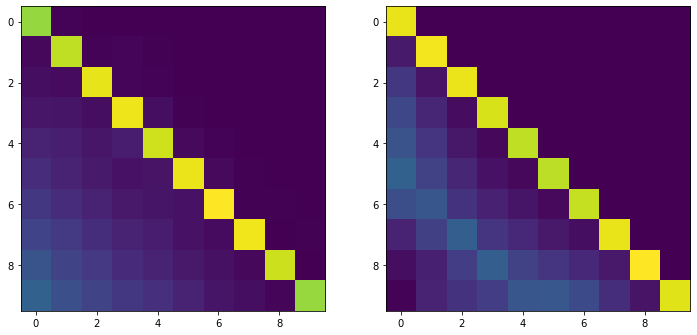

In [ ]:
g1_variance_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_1_variance.sample, second_kwargs={"transpose": True}),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)
g2_variance_pq = coupling_util.joint_from_samples(
    coupling_util.sampler_from_common_random_numbers(gadget_2_variance.sample),
    logits_1=p_logits,
    logits_2=q_logits,
    rng=jax.random.PRNGKey(42),
    num_samples=100_000)

_, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].imshow(g1_variance_pq, vmin=0)
axs[1].imshow(g2_variance_pq, vmin=0)

If they are trained to reduce variance, Gadget 2 learns a coupling that shares some similarity with the inverse CDF coupling, whereas Gadget 1 again pulls a large amount of mass onto the diagonal.

